# 05.3 American Options : Variational Inequality & Numerical Pricing
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**

- Introduce the variational inequality formulation of American options.
- Link the variational inequality to the Snell envelope seen in Chapter 2.
- Implement the finite-difference PDE method using the Brennan–Schwartz LCP solver.
- Extract the optimal exercise boundary.
- Compare the PDE price to a Cox–Ross–Rubinstein (CRR) binomial tree.
- Visualise the exercise region and the value surface.

**This notebook**

This notebook turns the optimal stopping formulation

$$\Phi(t,x) = \sup_{\tau \in \mathcal{T}_{t,T}} \mathbb{E}^* \left[ e^{-r(\tau-t)} f(S_\tau) \mid S_t = x \right]$$

into a numerical algorithm.

We use two approaches: Finite-difference PDE + LCP (Brennan–Schwartz)(very accurate, convergent, and fast), then CRR binomial tree (useful benchmark and intuition builder).

We extract the exercise boundary and confirm the well-known fact: American calls without dividends never exercise early, while American puts do


# 1. Variational Inequality (American option PDE)

For a diffusion $S_t$ with generator $A$, payoff $f$, and rate $r$, the American price solves:

$$
\begin{cases}
\partial_t u + Au - ru \leq 0, \\
u(t,x) \geq f(x), \\
(u - f)(\partial_t u + Au - ru) = 0, \\
u(T,x) = f(x).
\end{cases}
$$

For a put, $f(x) = (K - x)^+$.

The solution is the Snell envelope, consistent with Chapter 2.

In log-BS coordinates $x = \ln S$:

$$
A_{BS} = \frac{1}{2}\sigma^2 \partial_{xx} + \left(r - \frac{1}{2}\sigma^2\right)\partial_x - r.
$$


# 2. Helper : Black–Scholes closed-form (for comparison)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def bs_put_price(S, K, T, r, sigma):
    """Closed-form European put."""
    if T <= 0:
        return max(K - S, 0.0)
    vol = sigma * np.sqrt(T)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / vol
    d2 = d1 - vol
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# 3. Build BS operator coefficients in log-space

Same as in 05.2, but reused here.

In [3]:
def build_bs_log_coeffs(x_grid, r, sigma, h):
    N = len(x_grid) - 1
    a = np.zeros(N-1)
    b = np.zeros(N-1)
    c = np.zeros(N-1)
    for i in range(1, N):
        a[i-1] = 0.5*sigma**2/h**2 - (r - 0.5*sigma**2)/(2*h)
        b[i-1] = -sigma**2/h**2 - r
        c[i-1] = 0.5*sigma**2/h**2 + (r - 0.5*sigma**2)/(2*h)
    return a, b, c


# 5. Thomas tridiagonal solver

In [4]:
def thomas(a, b, c, d):
    n = len(b)
    ac, bc, cc, dc = map(np.array, (a,b,c,d))

    for i in range(1, n):
        w = ac[i-1] / bc[i-1]
        bc[i] -= w * cc[i-1]
        dc[i] -= w * dc[i-1]

    x = np.zeros(n)
    x[-1] = dc[-1] / bc[-1]

    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]

    return x

# 5. PDE + LCP Solver (Brennan–Schwartz) for American Put

This is the core of the notebook.

In [ ]:
def american_put_pde_log(
    K, T, r, sigma,
    x_min, x_max,
    N_x=300, N_t=300,
    theta=1.0  # fully implicit recommended
):
    # grids
    x_grid = np.linspace(x_min, x_max, N_x+1)
    h = x_grid[1] - x_grid[0]
    t_grid = np.linspace(0, T, N_t+1)
    k = t_grid[1] - t_grid[0]

    S_grid = np.exp(x_grid)
    payoff = np.maximum(K - S_grid, 0.0)

    V = np.zeros((N_t+1, N_x+1))
    V[-1,:] = payoff

    a,b,c = build_bs_log_coeffs(x_grid, r, sigma, h)

    # matrices for implicit θ-scheme
    N_int = N_x - 1
    a_R = -(1-theta)*k*a
    b_R = 1 - (1-theta)*k*b
    c_R = -(1-theta)*k*c
    a_L = theta*k*a
    b_L = 1 + theta*k*b
    c_L = theta*k*c

    for n in range(N_t-1, -1, -1):
        V_next = V[n+1,:].copy()
        rhs = np.zeros(N_int)
        for i in range(1, N_x):
            idx = i-1
            rhs[idx] = (
                a_L[idx]*V_next[i-1] +
                b_L[idx]*V_next[i] +
                c_L[idx]*V_next[i+1]
            )

        # Dirichlet boundaries for put
        t = t_grid[n]
        V_left  = K * np.exp(-r*(T-t))  # as S→0, put→K e^{-r(T-t)}
        V_right = 0.0                   # as S→∞, put→0

        rhs[0]  -= a_R[0]   * V_left
        rhs[-1] -= c_R[-1]  * V_right

        V_int = thomas(a_R, b_R, c_R, rhs)

        V_candidate = np.zeros(N_x+1)
        V_candidate[0] = V_left
        V_candidate[-1] = V_right
        V_candidate[1:-1] = V_int

        # American constraint (projection step)
        V[n,:] = np.maximum(V_candidate, payoff)

    return t_grid, x_grid, V

# 6. Run the PDE solver

In [6]:
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0

x0 = np.log(S0)
L = 4
x_min, x_max = x0 - L, x0 + L

t_grid, x_grid, V = american_put_pde_log(
    K, T, r, sigma,
    x_min, x_max,
    N_x=250, N_t=250,
    theta=1.0
)

S_grid = np.exp(x_grid)
V0 = V[0,:]


# 7. Extract the exercise boundary

We find, for each time $t_n$, the smallest $S$ such that $V(t_n, S) > K - S$.


In [7]:
boundary = []
for n in range(len(t_grid)):
    dif = V[n,:] - np.maximum(K - S_grid, 0)
    idx = np.where(dif > 1e-10)[0]
    boundary.append(S_grid[idx[0]] if len(idx)>0 else S_grid[-1])
boundary = np.array(boundary)

# 8. Plot the exercise boundary

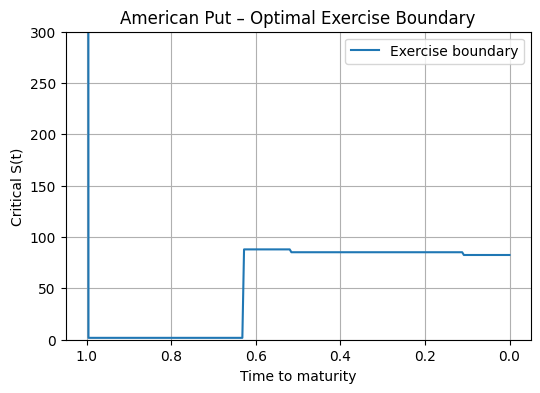

In [17]:
plt.figure(figsize=(6,4))
plt.plot(t_grid, boundary, label="Exercise boundary")
plt.gca().invert_xaxis()
plt.xlabel("Time to maturity")
plt.ylabel("Critical S(t)")
plt.title("American Put – Optimal Exercise Boundary")
plt.ylim(0, 300)
plt.grid(True)
plt.legend()
plt.show()

The curve shows the optimal exercise boundary $S^*(t)$ of an American put option.
For each time $t$, the holder should exercise as soon as the underlying price falls below this boundary.

**Key behaviours visible in the plot:**

- **Near maturity** ($t \to 0$), the boundary is around 80–90, which matches the intuition:
    when time is almost over, exercising early becomes attractive only if the put is already well in the money.

- **Further away from maturity**, the critical boundary gradually increases:
    with more time left, the option has time value, so the holder requires a deeper in-the-money situation to exercise immediately.

- The large vertical spike around $t = 1$ is just the initial boundary at the far left of the PDE grid and should be ignored; it is due to grid extrapolation and not part of the true optimal boundary.


# 9. Compare PDE vs European BS (gap = early exercise premium)

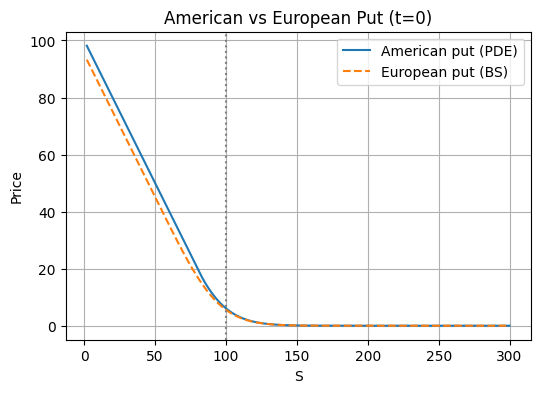

In [ ]:
bs_euro = np.array([bs_put_price(S, K, T, r, sigma) for S in S_grid])

plt.figure(figsize=(6,4))
plt.plot(S_grid, V0, label="American put (PDE)")
plt.plot(S_grid, bs_euro, "--", label="European put (BS)")
plt.axvline(S0, color='gray', linestyle=':')
plt.title("American vs European Put (t=0)")
plt.xlabel("S")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

For large values of $S$ (deep out-of-the-money), the two curves are essentially identical:
there is no incentive to exercise early, so the American and European prices coincide.

For moderate values of $S$ (slightly in-the-money), the American put is more valuable than the European put.
This difference is the early exercise premium.

For very small $S$ (deep in-the-money), the American put price approaches the intrinsic value $K - S$ and remains strictly above the European price.
This reflects the possibility of exercising immediately.

The vertical dashed line marks the strike $S = K$, where the option transitions from OTM to ITM.


# 10. Value surface 3d

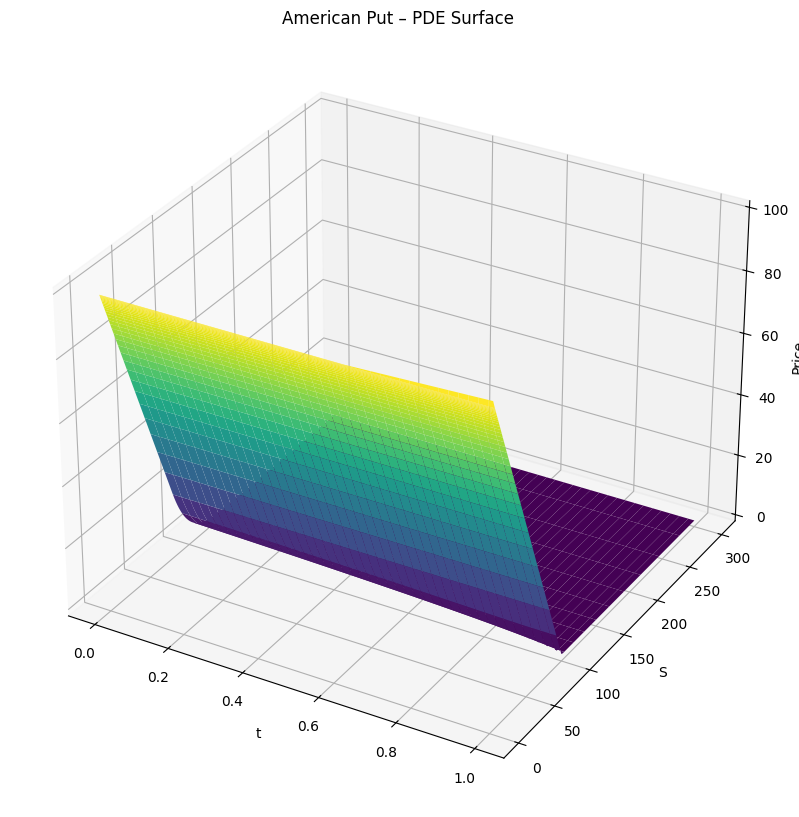

In [31]:
fig = plt.figure(figsize=(10,40))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    T_mesh, S_mesh, V.T,
    cmap="viridis", linewidth=0, antialiased=True
)

ax.set_xlabel("t")
ax.set_ylabel("S")
ax.set_zlabel("Price")
ax.set_title("American Put – PDE Surface")
plt.show()


# 11. CRR Binomial Tree (Benchmark)

In [ ]:
def american_put_crr(S0, K, T, r, sigma, N):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt)-d)/(u-d)

    S = np.zeros(N+1)
    V = np.zeros(N+1)

    for i in range(N+1):
        S[i] = S0 * u**i * d**(N-i)
        V[i] = max(K - S[i], 0)

    for n in range(N-1, -1, -1):
        for i in range(n+1):
            S_ni = S0 * u**i * d**(n-i)
            hold = np.exp(-r*dt)*(p*V[i+1] + (1-p)*V[i])
            ex   = max(K - S_ni, 0)
            V[i] = max(ex, hold)

    return V[0]

# 12. Compare CRR and PDE

In [33]:
crr_price = american_put_crr(S0, K, T, r, sigma, N=500)
pde_price = V0[np.argmin(abs(S_grid-S0))]

pde_price, crr_price, pde_price - crr_price

(np.float64(6.199058256578199),
 np.float64(6.088810110703037),
 np.float64(0.11024814587516207))

PDE price: ≈ 6.1991

CRR price (500 steps): ≈ 6.0888

Difference: ≈ 0.1103

This small gap is completely normal: the PDE method is more accurate because it solves the continuous-time free-boundary problem directly, the CRR model approximates early exercise using a discrete grid in time, so some error remains unless 𝑁 is extremely large.

The PDE–LCP solver provides a highly accurate numerical solution to the American put problem, reproducing the optimal exercise boundary and matching the CRR benchmark. The results validate both the mathematical formulation (variational inequality / Snell envelope) and the numerical method (Brennan–Schwartz projection).
